# Hate Speech Detector 2.0
---
**Best classifiers testing**
1. Load best models of each classification method.
2. Perform multilabel classification task with each of models.
3. Put results: accuracy, precision, recall anf F measure for each of hate-speech classes and overall into table.
4. Get classification model with F measure for overall postive examples. Winner model.
5. Compare project results with results from literature.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.dataframes.utils import classes, combine_row_wisely, models_quality_results
from src.visualization.classification import confusion_matrices, models_metric_bars, models_quality_plot, best_model_for_class

from src.classifiers.DLVectorClassifier import DLVectorClassifier
from src.best_models import NAMES, TYPES, SHORT_NAMES, PARAMETERS, CLF_CLASSES, CLF_KWARGS
from src.constants import (DUPLICATED_PATH, COMBINED_TESTONLY_PATH,
                           POC_SCORES_PATH, POC_SCORES_TESTONLY_PATH,
                           TOPIC_POC_SCORES_PATH, TOPIC_POC_SCORES_TESTONLY_PATH,
                           OTHER_SCORES_PATH, OTHER_SCORES_TESTONLY_PATH,
                           LABELS,
                           BEST_CHART_DIR, RESULTS_DIR)

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:

    y_pred = clf.predict(X_test_data)
    confusion_matrices(y_test_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score for model: {short_name}.',
                       percentage=True, show_acc=True,
                       save_file=BEST_CHART_DIR.replace('{}', f'confusion_matrices_{short_name}'))
    y_preds_TT.append(y_pred_TT)
    y_preds.append(y_pred)plt.style.use('ggplot')

There are several types of classification. First **lexical** bases only on POC (Phrase Occurence Coefficient) features. Second **simple machine learning** uses classifiers like: Decision Tree or Random Forest which may use POC features as well as vectorized texts. Third type **simple deep learning** uses simple neural networks (Dense 1D Convolutional or Recurrent). The more complex neural networks (ex. 1d Convolutional + LSTM) denote **complex deep learning** classification. **Advanced deep learning** classification are neural networks with improved hyperparameter (i.e. optimizers with regularizers and learning rate schedulers).

## Data loading

### Classes

In [4]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


In [5]:
df_test_classes = pd.read_csv(COMBINED_TESTONLY_PATH)[LABELS]
df_test_classes = classes(df_test_classes, convert_null=True)
df_test_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Tweet POC scores for each class

In [6]:
df_poc_scores = pd.read_csv(POC_SCORES_PATH).drop(['id'], axis=1)
df_poc_scores.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,pon_POC_max,styg_POC_min,styg_POC_mean,styg_POC_max,szan_POC_min,szan_POC_mean,szan_POC_max,vulg_POC_min,vulg_POC_mean,vulg_POC_max
0,0.000000,0.000000,0.0,-0.5,-0.002193,0.5,0.0,0.000000,0.000000,0.0,...,0.5,-0.5,0.000260,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.333333,0.004526,0.5,-0.5,0.000808,0.5,0.0,0.006219,0.333333,-0.5,...,0.5,-0.5,-0.004606,0.333333,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_test_poc_scores = pd.read_csv(POC_SCORES_TESTONLY_PATH).drop(['id'], axis=1)
df_test_poc_scores.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,pon_POC_max,styg_POC_min,styg_POC_mean,styg_POC_max,szan_POC_min,szan_POC_mean,szan_POC_max,vulg_POC_min,vulg_POC_mean,vulg_POC_max
0,0.0,0.0,0.0,-0.5,-0.001731,0.00,0.0,0.0,0.0,0.000000,...,0.500000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,-0.5,-0.001385,0.25,0.0,0.0,0.0,-0.333333,...,0.333333,-0.5,-0.000152,0.5,0.0,0.0,0.0,0.0,0.0,0.0


### Tweet topic POC for each class

In [8]:
df_topic_poc_scores = pd.read_csv(TOPIC_POC_SCORES_PATH).drop(['id'], axis=1)
df_topic_poc_scores.head(2)

,wyz_topic_POC_min,wyz_topic_POC_mean,wyz_topic_POC_max,groz_topic_POC_min,groz_topic_POC_mean,groz_topic_POC_max,wyk_topic_POC_min,wyk_topic_POC_mean,wyk_topic_POC_max,odcz_topic_POC_min,...,pon_topic_POC_max,styg_topic_POC_min,styg_topic_POC_mean,styg_topic_POC_max,szan_topic_POC_min,szan_topic_POC_mean,szan_topic_POC_max,vulg_topic_POC_min,vulg_topic_POC_mean,vulg_topic_POC_max
0,0.0,0.000000,0.000000,-0.052632,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,...,0.052632,-0.052632,0.002632,0.052632,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.005263,0.052632,-0.052632,-0.010526,0.000000,-0.052632,-0.002632,0.052632,-0.052632,...,0.000000,-0.052632,-0.010526,0.052632,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_test_topic_poc_scores = pd.read_csv(TOPIC_POC_SCORES_TESTONLY_PATH).drop(['id'], axis=1)
df_test_topic_poc_scores.head(2)

,wyz_topic_POC_min,wyz_topic_POC_mean,wyz_topic_POC_max,groz_topic_POC_min,groz_topic_POC_mean,groz_topic_POC_max,wyk_topic_POC_min,wyk_topic_POC_mean,wyk_topic_POC_max,odcz_topic_POC_min,...,pon_topic_POC_max,styg_topic_POC_min,styg_topic_POC_mean,styg_topic_POC_max,szan_topic_POC_min,szan_topic_POC_mean,szan_topic_POC_max,vulg_topic_POC_min,vulg_topic_POC_mean,vulg_topic_POC_max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.052632,...,0.0,-0.052632,-0.002632,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tweet other scores

In [10]:
df_other_scores = pd.read_csv(OTHER_SCORES_PATH).drop(['id'], axis=1)
df_other_scores.head(2)

,s_neg,s_neu,s_pos,n_chars,n_sylls,n_words,nu_words,nl_chars,nl_sylls,nl_words,nlu_words
0,0,6,1,36,15,7,7,35,13,7,7
1,1,18,1,94,38,18,18,88,33,16,16


In [11]:
df_test_other_scores = pd.read_csv(OTHER_SCORES_TESTONLY_PATH).drop(['id'], axis=1)
df_test_other_scores.head(2)

,s_neg,s_neu,s_pos,n_chars,n_sylls,n_words,nu_words,nl_chars,nl_sylls,nl_words,nlu_words
0,0,15,0,73,28,13,13,66,23,12,12
1,1,15,0,81,28,15,13,76,24,17,14


### Lexical combined data

In [12]:
unused_fields = ['vulg_POC_min', 'vulg_POC_mean', 'vulg_POC_max']

df_lex_data = combine_row_wisely([df_poc_scores.drop(unused_fields, axis=1), df_classes])
df_lex_data.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,szan_POC_min,szan_POC_mean,szan_POC_max,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0.000000,0.000000,0.0,-0.5,-0.002193,0.5,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,-0.333333,0.004526,0.5,-0.5,0.000808,0.5,0.0,0.006219,0.333333,-0.5,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [13]:
df_test_lex_data = combine_row_wisely([df_test_poc_scores.drop(unused_fields, axis=1), df_test_classes])
df_test_lex_data.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,szan_POC_min,szan_POC_mean,szan_POC_max,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0.0,0.0,0.0,-0.5,-0.001731,0.00,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,-0.5,-0.001385,0.25,0.0,0.0,0.0,-0.333333,...,0.0,0.0,0.0,0,0,0,0,0,0,0


### Simple feature ML combined data

In [14]:
df_simpleML_data = combine_row_wisely([df_poc_scores, df_topic_poc_scores,
                                       df_other_scores, df_classes])
df_simpleML_data.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,nl_sylls,nl_words,nlu_words,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0.000000,0.000000,0.0,-0.5,-0.002193,0.5,0.0,0.000000,0.000000,0.0,...,13,7,7,0,0,0,0,0,0,0
1,-0.333333,0.004526,0.5,-0.5,0.000808,0.5,0.0,0.006219,0.333333,-0.5,...,33,16,16,0,0,0,0,0,0,0


In [15]:
df_test_simpleML_data = combine_row_wisely([df_test_poc_scores, df_test_topic_poc_scores,
                                            df_test_other_scores, df_test_classes])
df_test_simpleML_data.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,nl_sylls,nl_words,nlu_words,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0.0,0.0,0.0,-0.5,-0.001731,0.00,0.0,0.0,0.0,0.000000,...,23,12,12,0,0,0,0,0,0,0
1,0.0,0.0,0.0,-0.5,-0.001385,0.25,0.0,0.0,0.0,-0.333333,...,24,17,14,0,0,0,0,0,0,0


### Lemmatized tweets

In [16]:
df_lemmatized = pd.read_csv(DUPLICATED_PATH)[['tweet']]
df_lemmatized.head(2)

,tweet
0,w czwartek muszę poprawić sądy i trybunały
1,Żale Nałęcza i riposta Macierewicza: Pan był w...


In [17]:
df_test_lemmatized = pd.read_csv(COMBINED_TESTONLY_PATH)[['tweet']]
df_test_lemmatized.head(2)

,tweet
0,"Warto poznać Śląsk i Ślązaków, zanim zacznie s..."
1,jeszcze nie są całkiem bezkarni.Sądy jeszcze t...


### Lemmatized combined data

In [18]:
df_data = combine_row_wisely([df_lemmatized, df_classes])
df_data.head(2)

,tweet,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,w czwartek muszę poprawić sądy i trybunały,0,0,0,0,0,0,0
1,Żale Nałęcza i riposta Macierewicza: Pan był w...,0,0,0,0,0,0,0


In [19]:
df_test_data = combine_row_wisely([df_test_lemmatized, df_test_classes])
df_test_data.head(2)

,tweet,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,"Warto poznać Śląsk i Ślązaków, zanim zacznie s...",0,0,0,0,0,0,0
1,jeszcze nie są całkiem bezkarni.Sądy jeszcze t...,0,0,0,0,0,0,0


## Best models loading and running

In [20]:
y_preds_TT, y_preds, acc, fsc = list([]), list([]), list([]), list([])

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


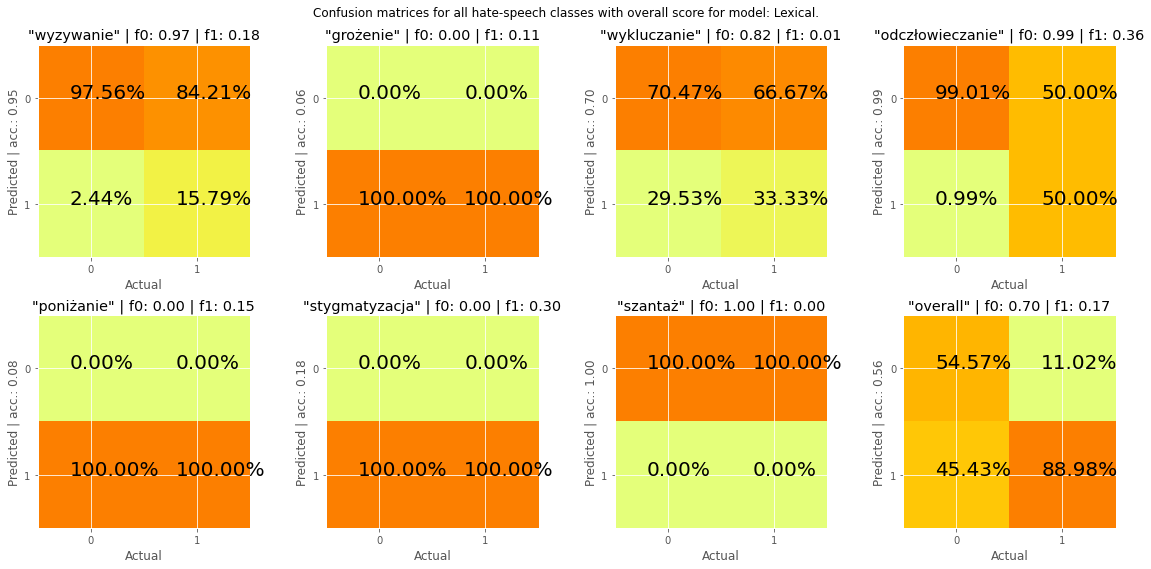

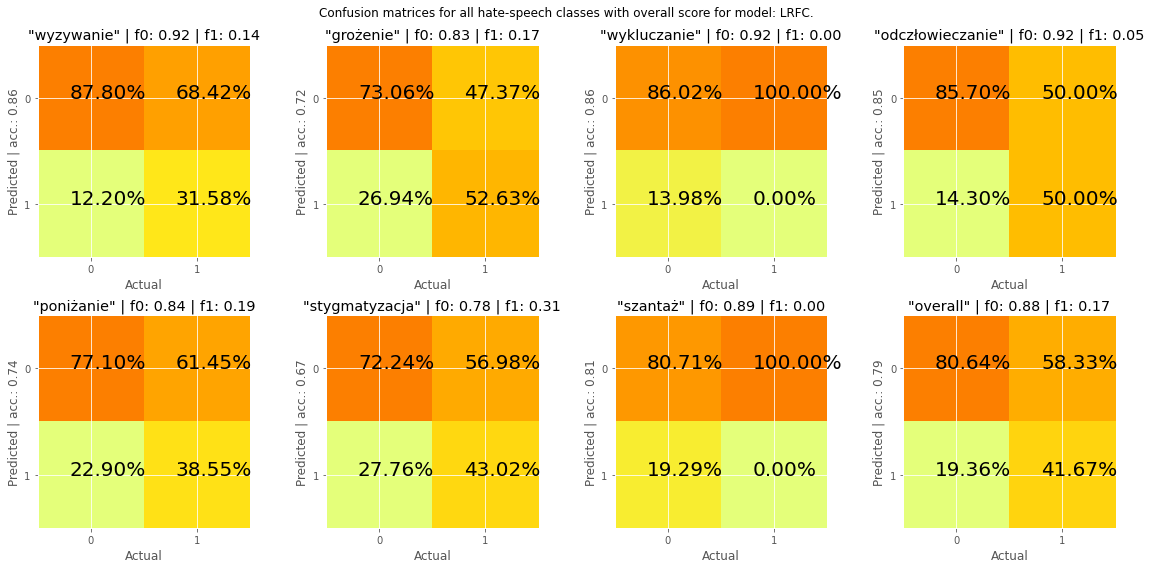

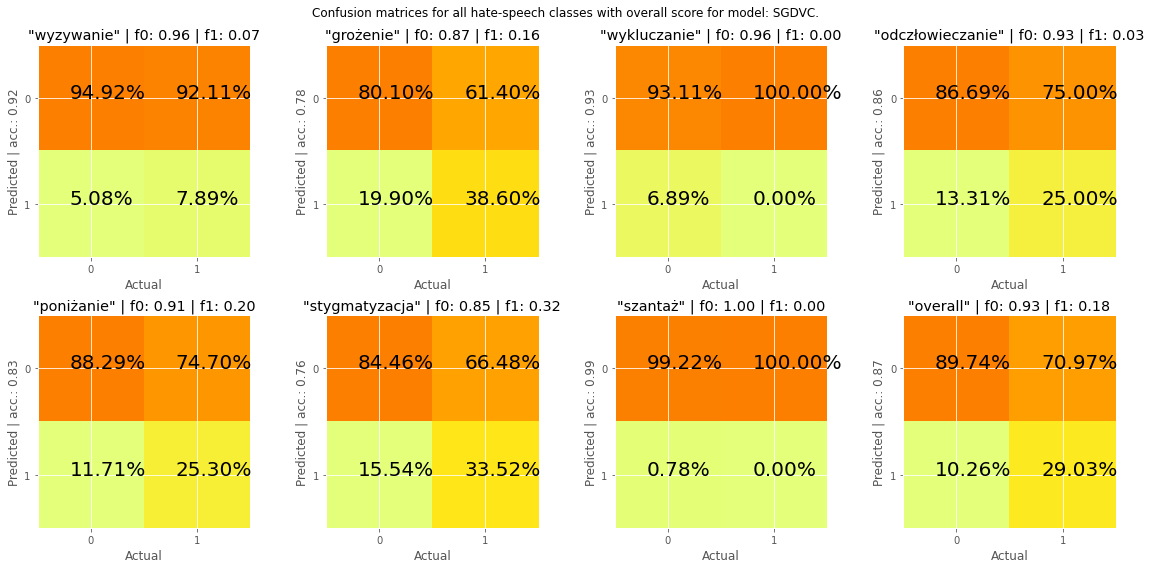

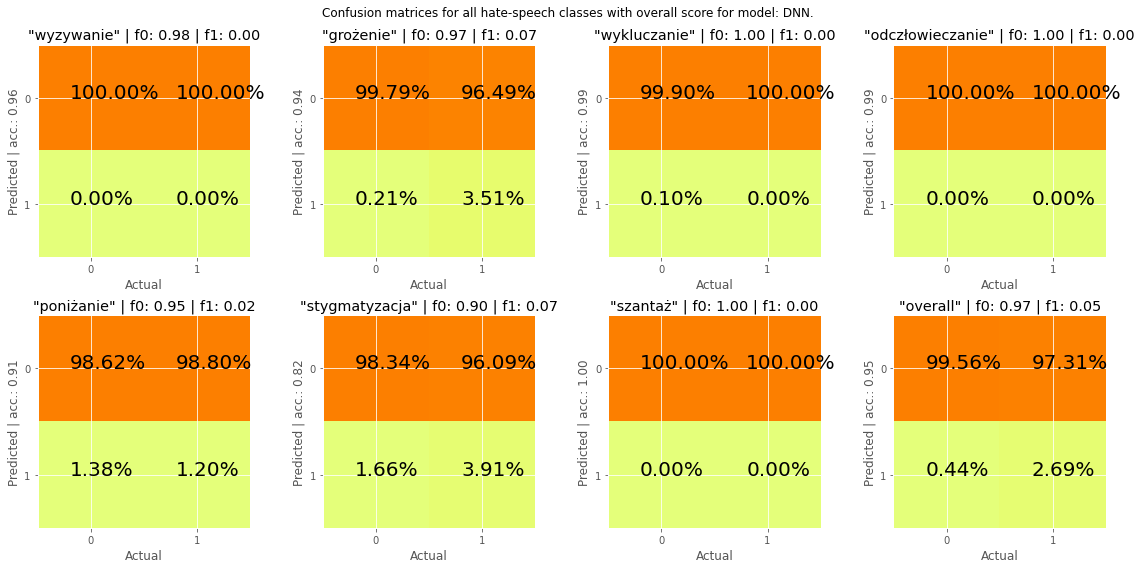

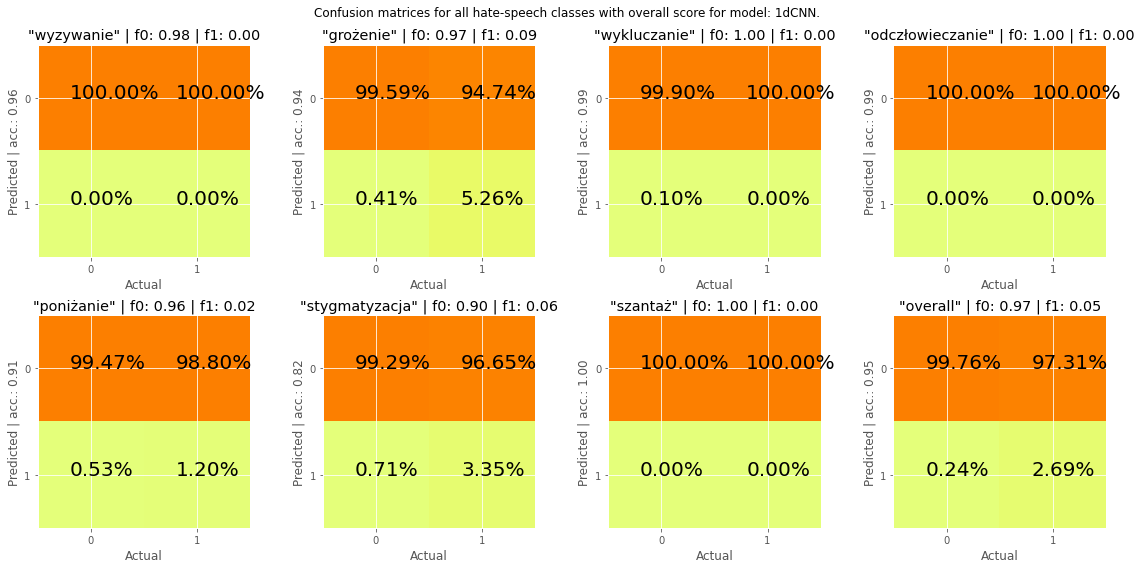

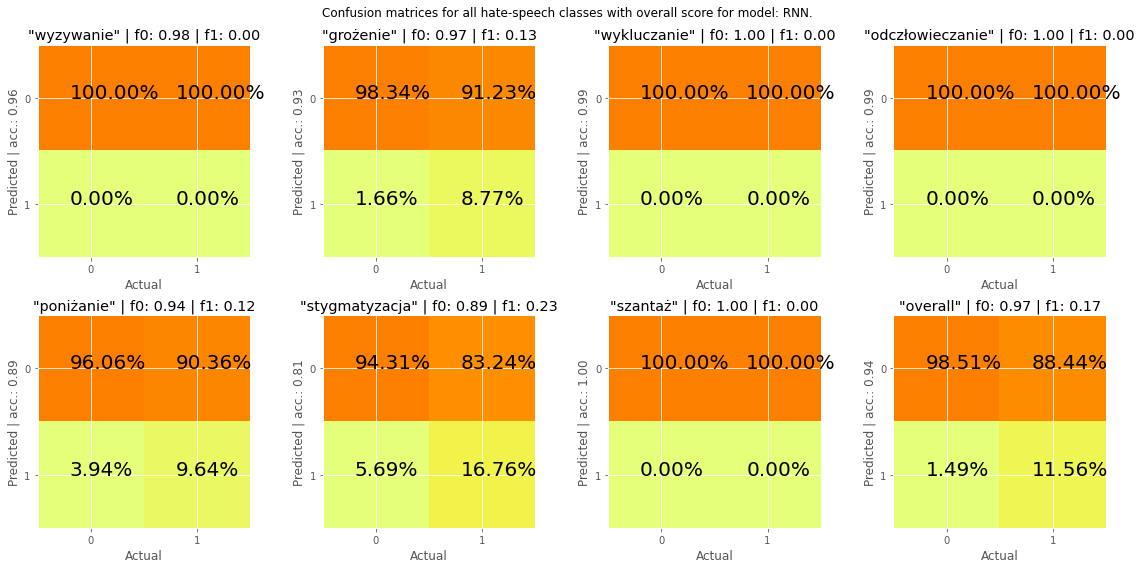

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


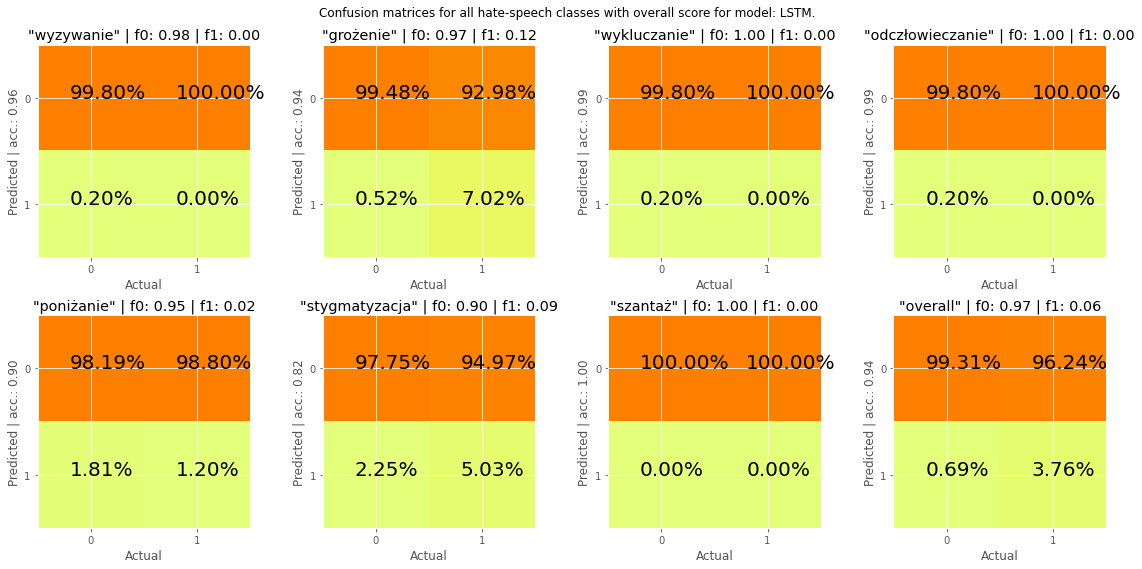

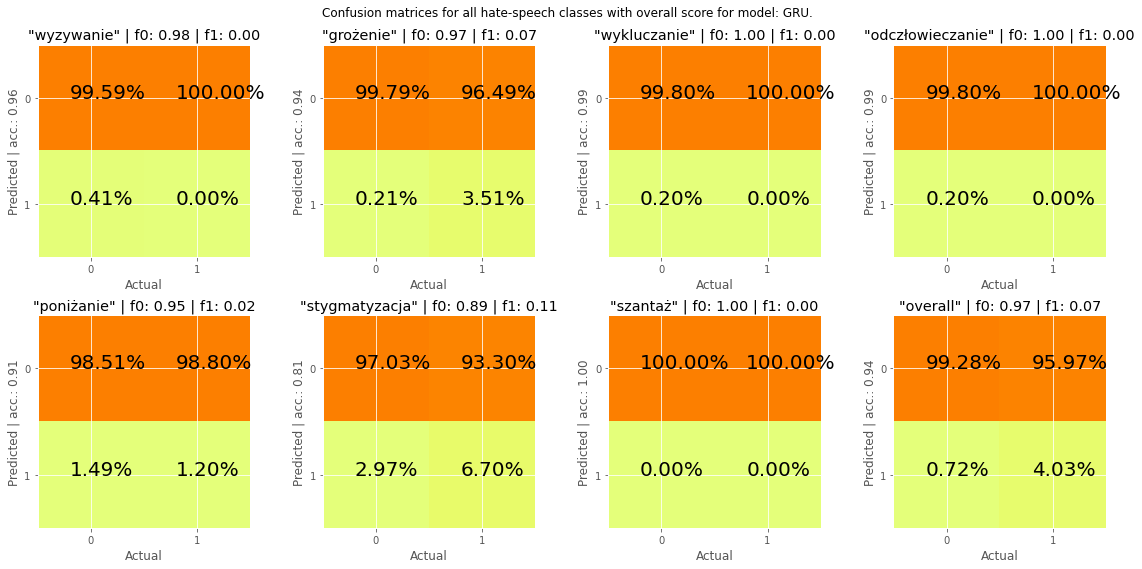

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


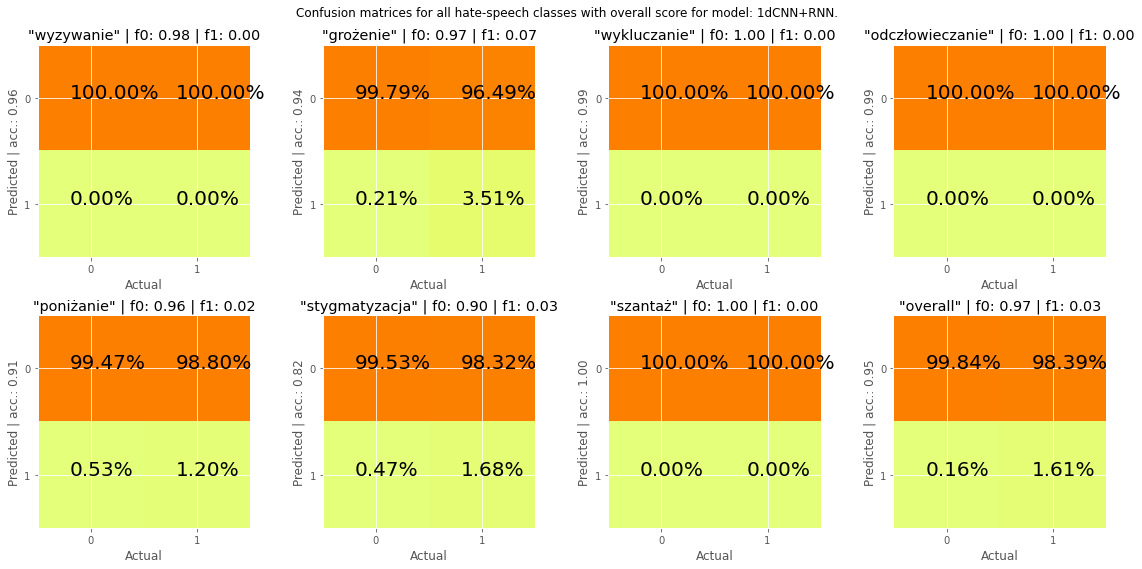

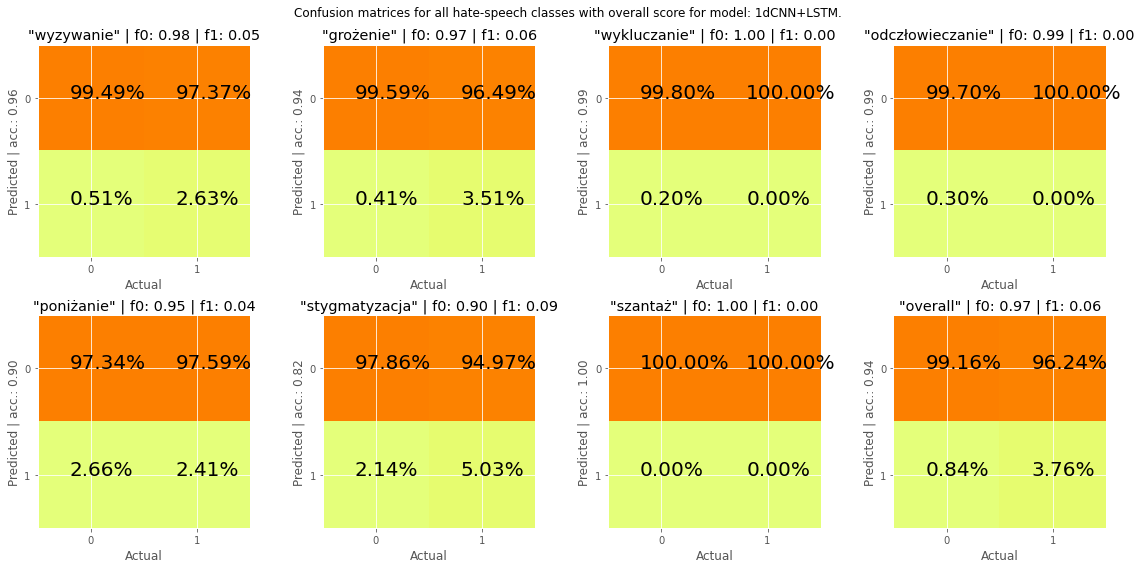

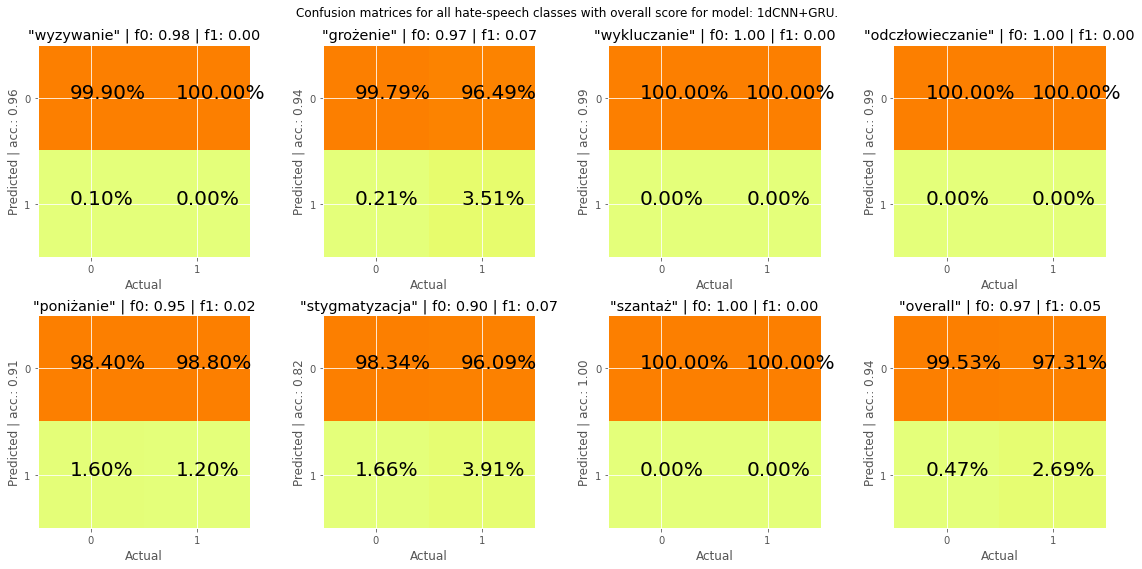

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/classifiers/DLVectorClassifier.py:123: RuntimeWarning: overflow encountered in exp
  return np.array([1/(1 + np.exp(-xx)) for xx in x])


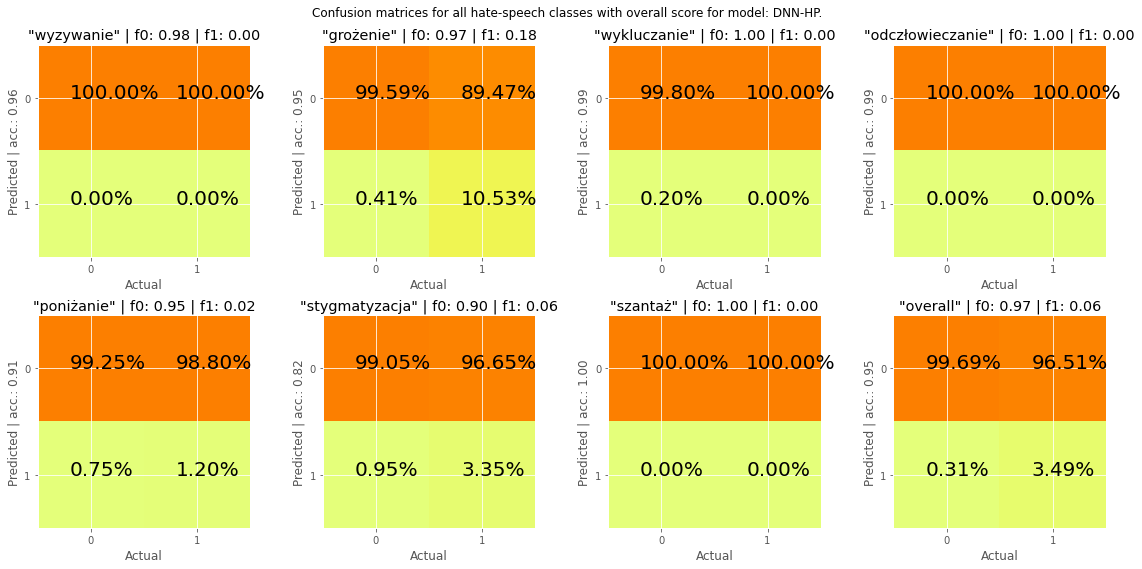

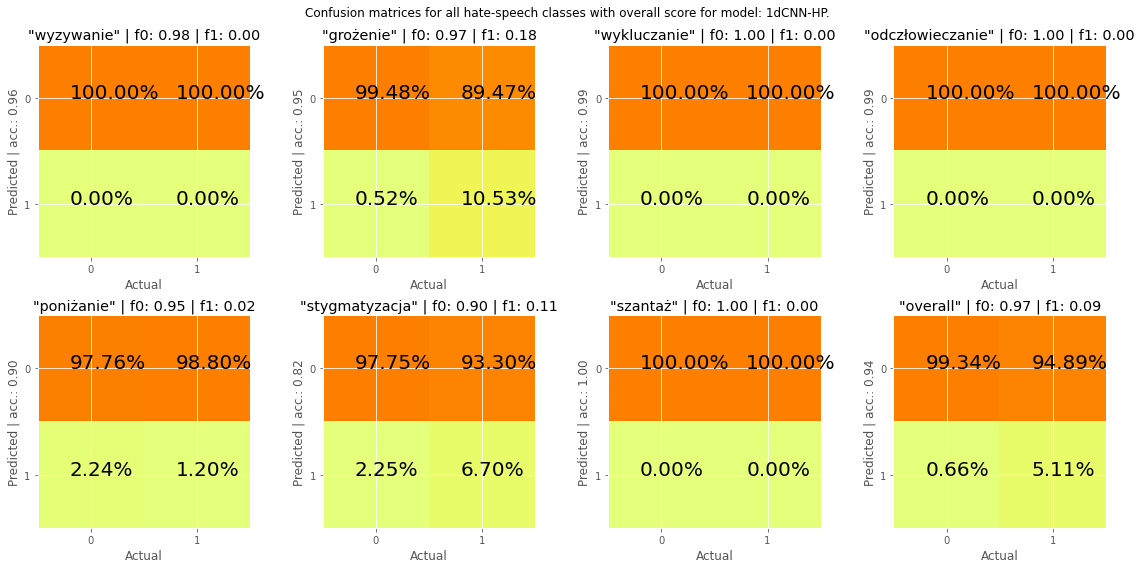

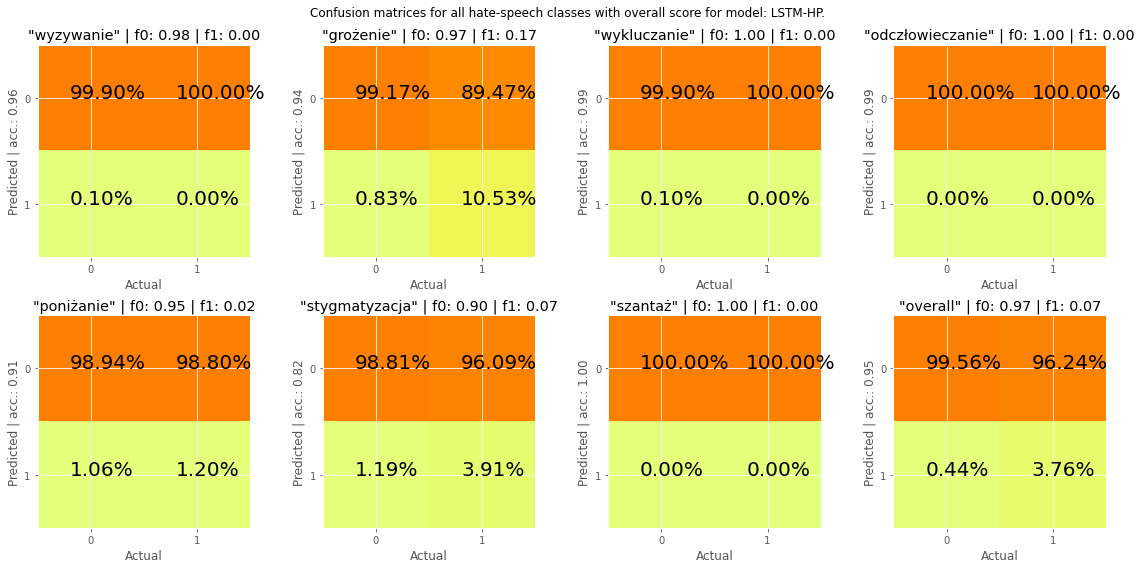

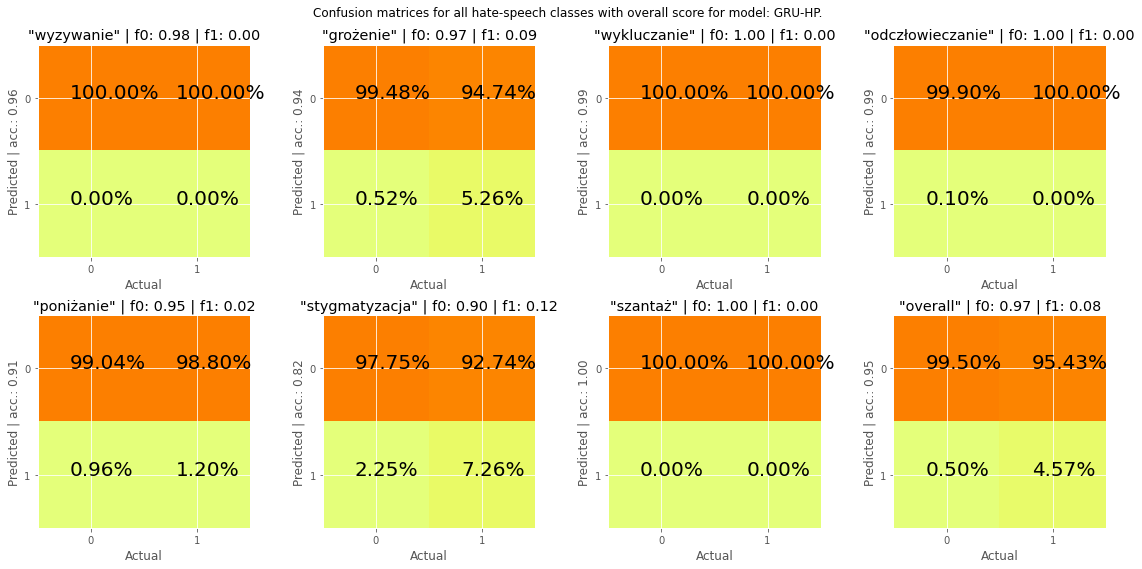

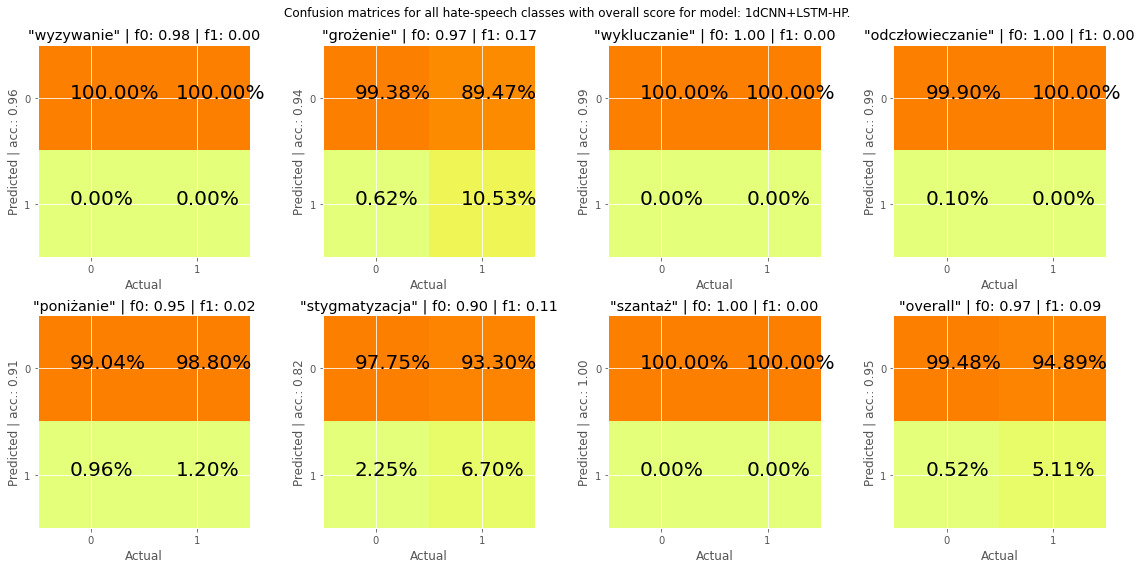

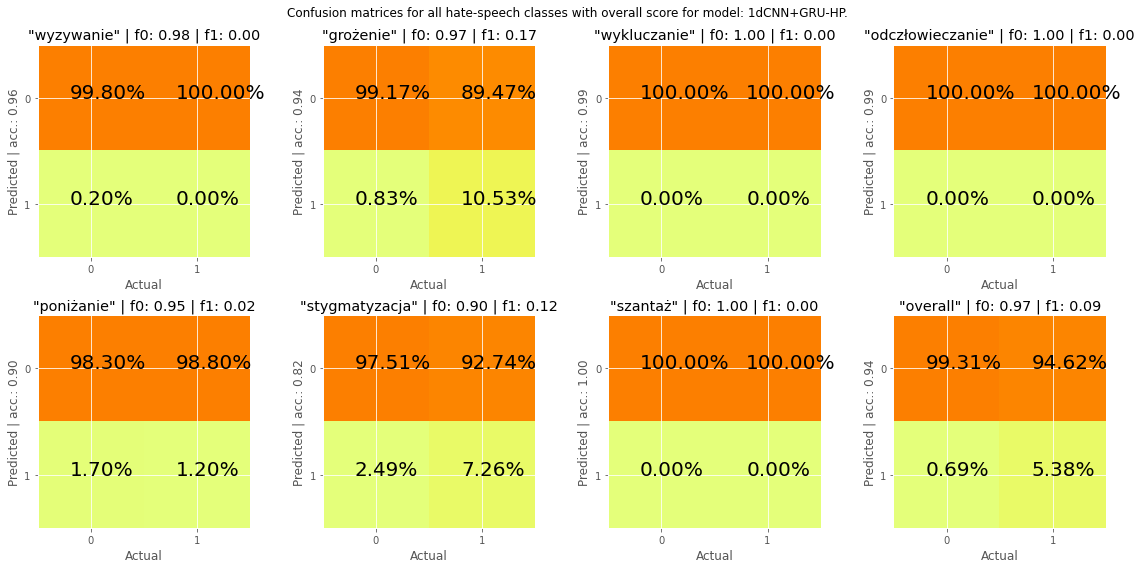

In [21]:
for clf_class, short_name, clf_kwargs in tqdm(zip(CLF_CLASSES, SHORT_NAMES, CLF_KWARGS),
                                              total=len(SHORT_NAMES), leave=False):
    if short_name == 'Lexical':
        X_data = df_lex_data.drop(LABELS, axis=1).values
        y_data = df_lex_data[LABELS].values
        X_test_data = df_test_lex_data.drop(LABELS, axis=1).values
        y_test_data = df_test_lex_data[LABELS].values
    elif short_name == 'LRFC':
        X_data = df_simpleML_data.drop(LABELS, axis=1).values
        y_data = df_simpleML_data[LABELS].values
        X_test_data = df_test_simpleML_data.drop(LABELS, axis=1).values
        y_test_data = df_test_simpleML_data[LABELS].values
    else:
        X_data = df_data.drop(LABELS, axis=1).values
        y_data = df_data[LABELS].values
        X_test_data = df_test_data.drop(LABELS, axis=1).values
        y_test_data = df_test_data[LABELS].values
        
    clf = clf_class(**clf_kwargs)
    clf.load()
    
    if clf_class == DLVectorClassifier:
        acc.append(np.max(clf.metrics[3]))  # validation accuracy
        fsc.append(np.max(clf.metrics[4]))  # mean validation F
    
    y_pred_TT = clf.predict(X_data)
    y_pred = clf.predict(X_test_data)
    confusion_matrices(y_test_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score for model: {short_name}.',
                       percentage=True, show_acc=True,
                       save_file=BEST_CHART_DIR.replace('{}', f'confusion_matrices_{short_name}'))
    y_preds_TT.append(y_pred_TT)
    y_preds.append(y_pred)
y_preds_TT = np.array(y_preds_TT)
y_preds = np.array(y_preds)

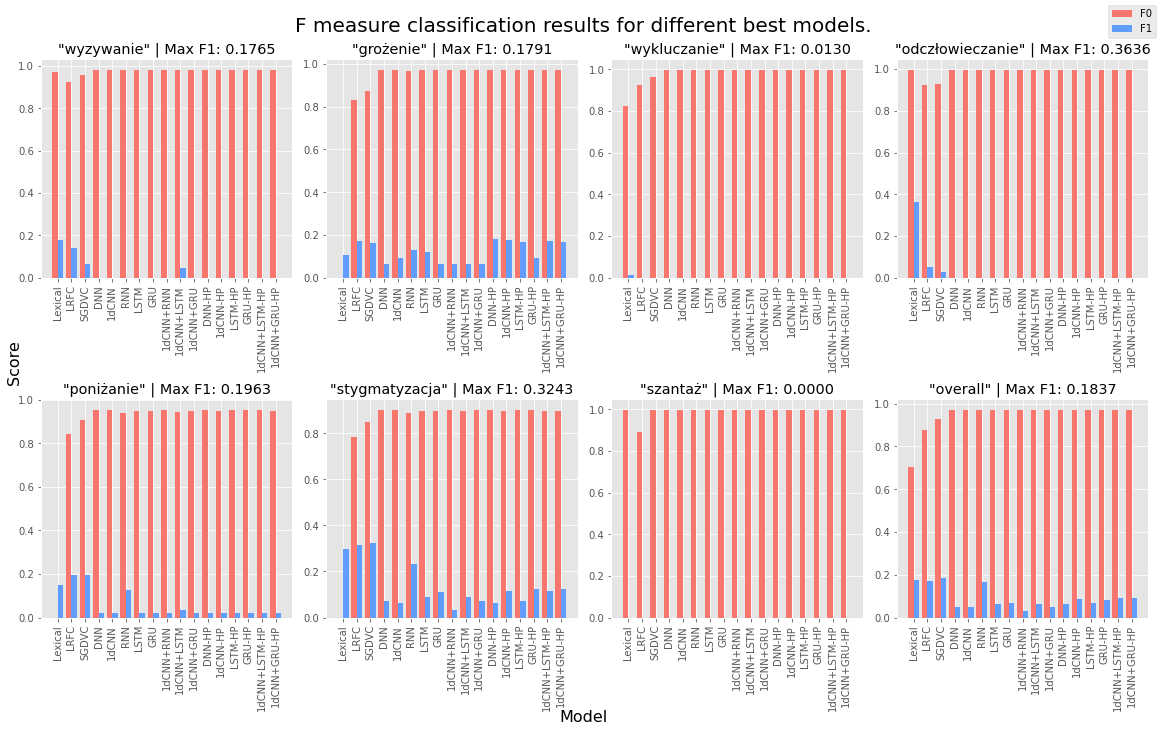

In [22]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=SHORT_NAMES,
                    title='F measure classification results for different best models.',
                    measure='f', colors=['#f9766e', '#619dff'],
                    save_file=BEST_CHART_DIR.replace('{}', f'models_F_bars'))

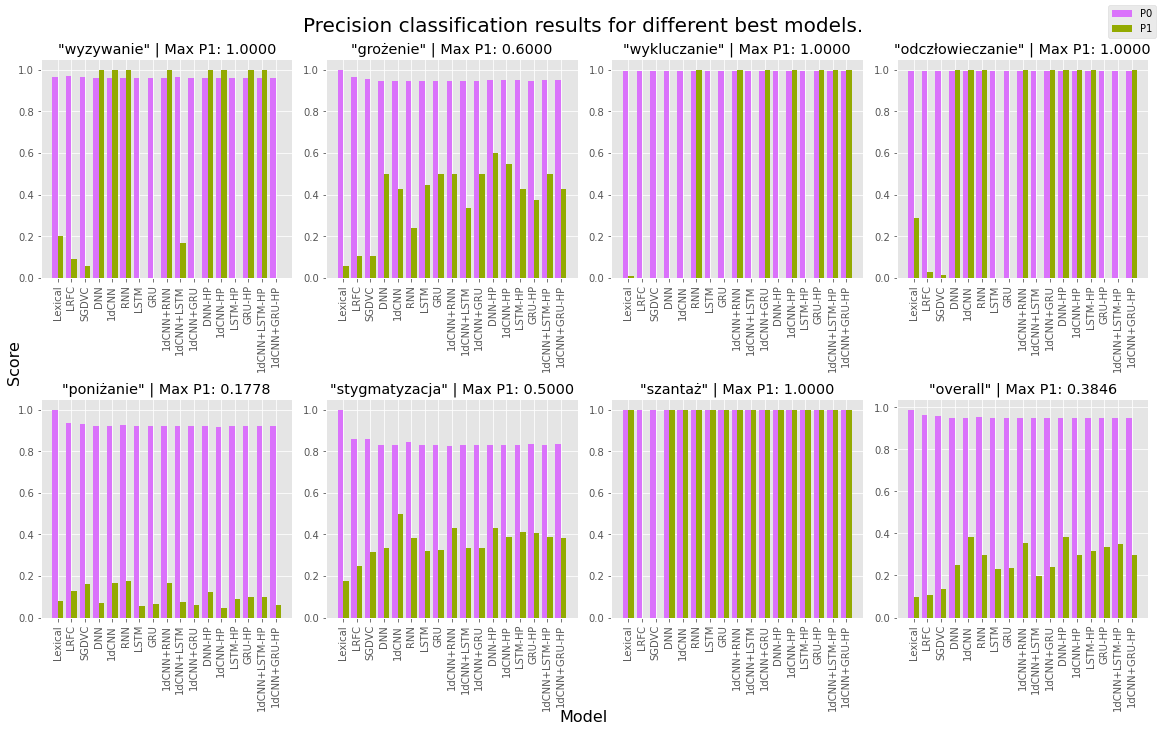

In [23]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=SHORT_NAMES,
                    title='Precision classification results for different best models.',
                    measure='p', colors=['#da72fb', '#93aa00'],
                    save_file=BEST_CHART_DIR.replace('{}', f'models_P_bars'))

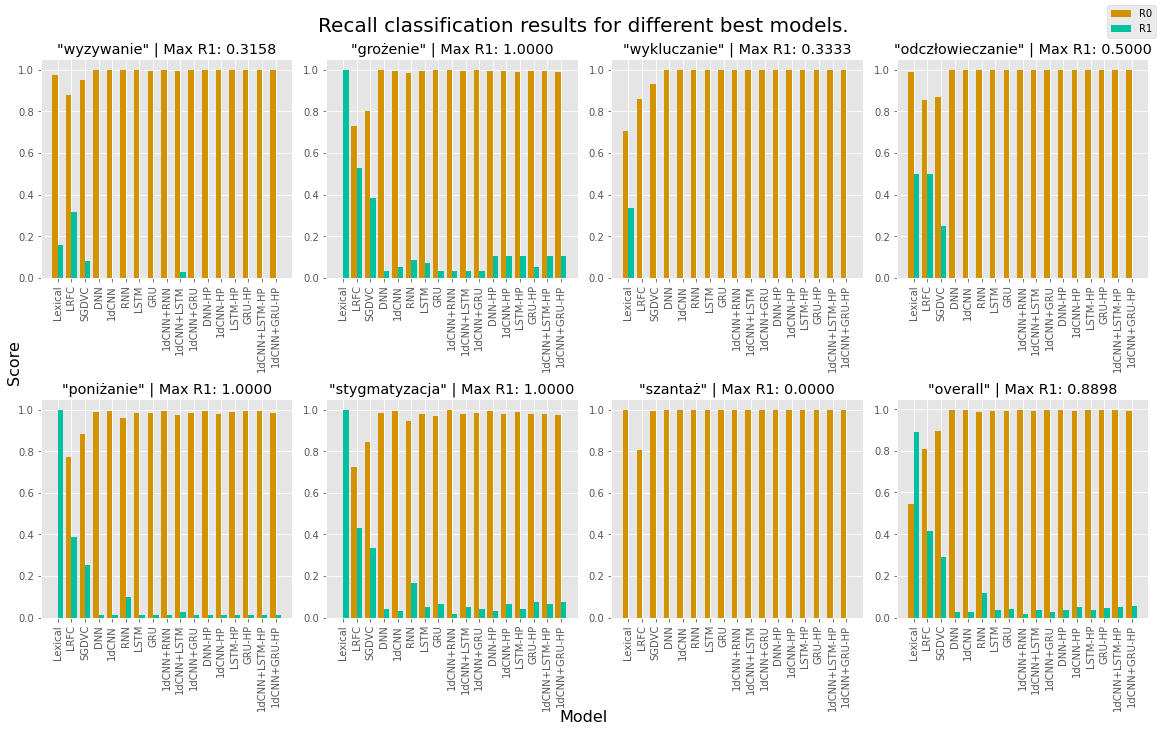

In [24]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=SHORT_NAMES,
                    title='Recall classification results for different best models.',
                    measure='r', colors=['#d39200', '#00c19f'],
                    save_file=BEST_CHART_DIR.replace('{}', f'models_R_bars'))

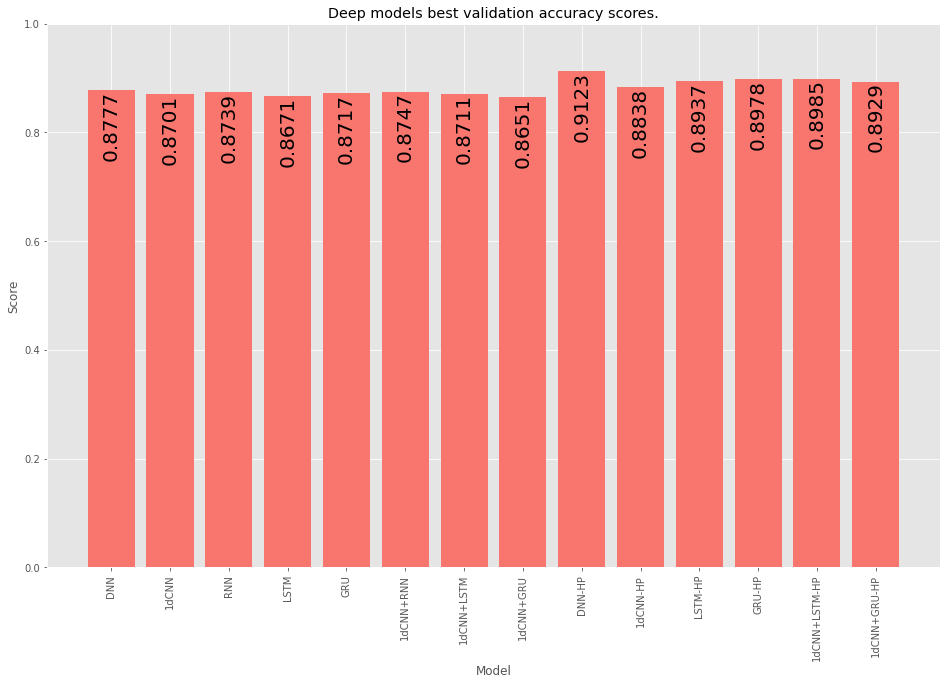

In [25]:
models_metric_bars(labels=SHORT_NAMES[3:], metrics=acc, title='Deep models best validation accuracy scores.',
                   color='#f9766e', save_file=BEST_CHART_DIR.replace('{}', 'deep_models_valid_A_bars'))

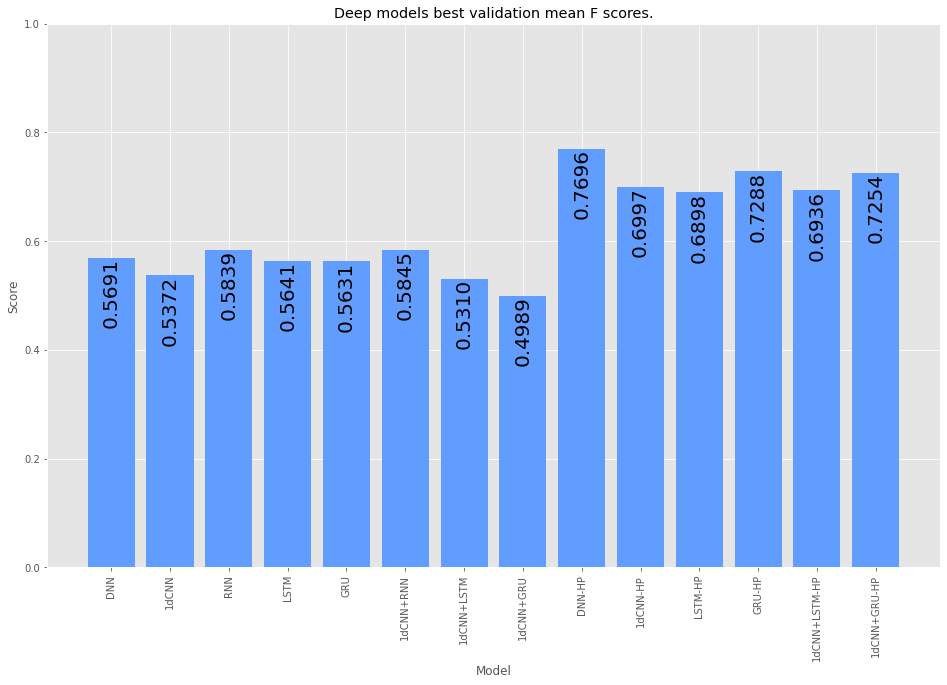

In [26]:
models_metric_bars(labels=SHORT_NAMES[3:], metrics=fsc, title='Deep models best validation mean F scores.',
                   color='#619dff', save_file=BEST_CHART_DIR.replace('{}', 'deep_models_valid_F_bars'))

## Best models results

In [27]:
models_quality_results(y_trues=y_data, y_preds_s=y_preds_TT, model_names=SHORT_NAMES,
                       additionals=[NAMES, TYPES, PARAMETERS],
                       additional_titles=['name', 'type', 'classifier parameters'],
                       save_file=RESULTS_DIR.replace('{}', 'best_models_train_results'))

models_quality_results(y_trues=y_test_data, y_preds_s=y_preds, model_names=SHORT_NAMES,
                       additionals=[NAMES, TYPES, PARAMETERS],
                       additional_titles=['name', 'type', 'classifier parameters'],
                       save_file=RESULTS_DIR.replace('{}', 'best_models_results'))

,wyzywanie_A,wyzywanie_P0,wyzywanie_P1,wyzywanie_mean_P,wyzywanie_R0,wyzywanie_R1,wyzywanie_mean_R,wyzywanie_F0,wyzywanie_F1,wyzywanie_mean_F,...,overall_mean_P,overall_R0,overall_R1,overall_mean_R,overall_F0,overall_F1,overall_mean_F,name,type,classifier parameters
model,,,,,,,,,,,,,,,,,,,,,
Lexical,0.945205,0.967742,0.200000,0.583871,0.975610,0.157895,0.566752,0.971660,0.176471,0.574065,...,0.543027,0.545709,0.889785,0.717747,0.703345,0.174947,0.439146,Lexical Classifier,lexical,{}
LRFC,0.857143,0.970787,0.090909,0.530848,0.878049,0.315789,0.596919,0.922092,0.141176,0.531634,...,0.533711,0.806399,0.416667,0.611533,0.877286,0.168478,0.522882,Logistic Regression Feature Classifier,simple machine learning,"{penalty: l2, solver: liblinear, class_weight:..."
SGDVC,0.916830,0.963880,0.056604,0.510242,0.949187,0.078947,0.514067,0.956477,0.065934,0.511206,...,0.546377,0.897375,0.290323,0.593849,0.926896,0.183673,0.555285,Stochastic Gradient Descent Vector Classifier,simple machine learning,"{penalty: l2, class_weight: balanced}"
DNN,0.962818,0.962818,1.000000,0.981409,1.000000,0.000000,0.500000,0.981057,0.000000,0.490528,...,0.599557,0.995577,0.026882,0.511229,0.971790,0.048544,0.510167,Dense Neural Network Classifier,simple deep learning,"{hidden size: 300, dropout: 0.1, dense layers: 1}"
1dCNN,0.962818,0.962818,1.000000,0.981409,1.000000,0.000000,0.500000,0.981057,0.000000,0.490528,...,0.666915,0.997641,0.026882,0.512261,0.972825,0.050251,0.511538,1D Convolutional Neural Network Classifier,simple deep learning,"{channels: 32, kernel size: 3, conv. layers: 3}"
RNN,0.962818,0.962818,1.000000,0.981409,1.000000,0.000000,0.500000,0.981057,0.000000,0.490528,...,0.625839,0.985108,0.115591,0.550350,0.968823,0.166667,0.567745,Simple Recurrent Neural Network Classifier,simple deep learning,"{rec. layers: 5, dropout: 0.1, bidirectional: ..."
LSTM,0.960861,0.962745,0.000000,0.481373,0.997967,0.000000,0.498984,0.980040,0.000000,0.490020,...,0.589518,0.993070,0.037634,0.515352,0.970811,0.064665,0.517738,LSTM Neural Network Classifier,simple deep learning,"{rec. layers: 1, dropout: 0.1, bidirectional: ..."
GRU,0.958904,0.962672,0.000000,0.481336,0.995935,0.000000,0.497967,0.979021,0.000000,0.489510,...,0.592011,0.992775,0.040323,0.516549,0.970732,0.068807,0.519770,GRU Neural Network Classifier,simple deep learning,"{rec. layers: 1, dropout: 0., bidirectional: T..."
1dCNN+RNN,0.962818,0.962818,1.000000,0.981409,1.000000,0.000000,0.500000,0.981057,0.000000,0.490528,...,0.650830,0.998378,0.016129,0.507254,0.972915,0.030848,0.501882,1D Convolutional Recurrent Neural Network Clas...,complex deep learning,"{channels: 20, hidden size: 100, bidirectional..."


## Three best of best models

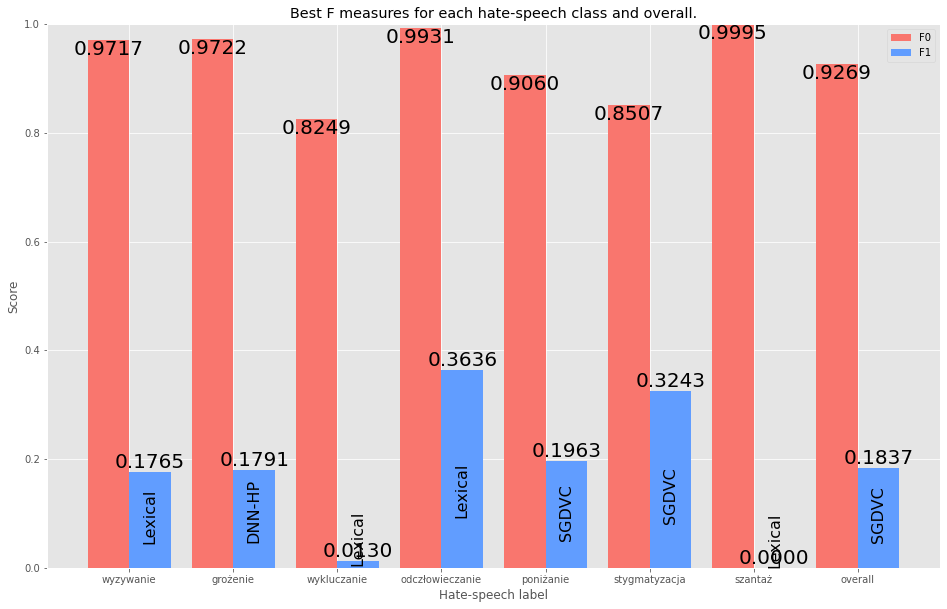

In [28]:
best_model_for_class(y_trues=y_test_data, y_preds_s=y_preds, model_names=SHORT_NAMES,
                     title='Best F measures for each hate-speech class and overall.',
                     save_file=BEST_CHART_DIR.replace('{}', f'best_F_bars'))

Judging by the above analyses (especially of testing dataset mean F measures) the **3-rd** place took **1D-CNN + GRU + FastText** model, the **2-nd** - **Stochastic Gradient Descent + FastText** and the **winner** is **Simple Recurrent Neural Network + FastText** model.

## Comparison with bibliographical positions
**NOTE:** Value within parentheses concerns training dataset and out of parentheses - testing dataset. Fields with one value (no parentheses) mean that there is no info whether the value refers to training or testing dataset, i.e. this was not provided by authors of a certain article.

| Bibliography position / project                                                                                                           | Model / dataset              | Accuracy        | Mean precision  | Mean recall     | Mean F measure  |
|-------------------------------------------------------------------------------------------------------------------------------------------|------------------------------|-----------------|-----------------|-----------------|-----------------|
| ,,Automatically Annotating A Five-Billion-Word Corpus of Japanese Blogs for Affect and Sentiment Analysis''                               | ML-Ask                       | 90.00%          | 85.70%          | 54.70%          | n/a             |
| ,,A Survey on Hate Speech Detection using Natural Language Processing''                                                                   | n/a                          | n/a             | n/a             | n/a             | n/a             |
| ,,Racial Bias in Hate Speech and Abusive Language Detection Datasets''                                                                    | Waseem & Hoovy               | n/a             | 76.67%          | 79.00%          | 77.67%          |
| ----\|\|----                                                                                                                              | Waseem                       | n/a             | 67.25%          | 76.00%          | 71.25%          |
| ----\|\|----                                                                                                                              | Davidson et al.              | n/a             | 69.67%          | 53.33%          | 73.00%          |
| ,,Hateful Symbols or Hateful People? Predictive Features for Hate Speech Detection on Twitter''                                           | word n-gram                  | n/a             | 64.39%          | 71.39%          | 64.58%          |
| ----\|\|----                                                                                                                              | character n-gram             | n/a             | 72.87%          | 77.75%          | 73.89%          |
| ,,Multi-label Hate Speech and Abusive Language Detection in Indonesian Twitter''                                                          | word n-gram                  | 73.53%          | n/a             | n/a             | n/a             |
| ----\|\|----                                                                                                                              | character n-gram             | 72.44%          | n/a             | n/a             | n/a             |
| ----\|\|----                                                                                                                              | lexicon                      | 52.10%          | n/a             | n/a             | n/a             |
| ,,Results of the PolEval 2019 Shared Task 6: first dataset and Open Shared Task for automatic cyberbullying detection in Polish Twitter'' | n-waves ULMFiT               | 90.10%          | 66.67%          | 52.24%          | 58.58%          |
| ----\|\|----                                                                                                                              | LMFiT + SentencePiece        | 87.40%          | 52.90%          | 54.48%          | 53.68%          |
| ----\|\|----                                                                                                                              | ensemble spacy + tpot + BERT | 87.30%          | 52.71%          | 50.75%          | 51.71%          |
| **,,Hate Speech Detector 2.0''**                                                                                                              | lexical                      | 56.36% (54.15%) | 54.30% (52.65%) | 71.77% (67.62%) | 43.91% (40.62%) |
| ----\|\|----                                                                                                                              | Logistic Regression          | 78.61% (78.63%) | 53.37% (53.40%) | 61.15% (65.25%) | 52.29% (51.71%) |
| ----\|\|----                                                                                                                              | **SGD + FastText**               | 86.58% (87.78%) | 54.64% (60.89%) | 59.38% (87.14%) | 55.53% (64.42%) |
| ----\|\|----                                                                                                                              | 1D-CNN + FastText            | 94.72% (96.52%) | 66.69% (76.73%) | 51.22% (78.07%) | 51.15% (77.38%) |
| ----\|\|----                                                                                                                              | **RNN + FastText**               | 93.99% (95.47%) | 62.58% (71.23%) | 55.03% (78.37%) | 56.77% (74.21%) |
| ----\|\|----                                                                                                                              | **1D-CNN+GRU NN + FastText**     | 94.42% (97.74%) | 62.44% (85.67%) | 52.34% (83.18%) | 53.12% (84.38%) |

The **best** hate speech detection model trained in project is **better than most** of the models presented in bibliographical positions. However, there are not any solutions based on multiclass multilabel classification.<br /> Despite the very low F mesures for postive examples, **THIS MIGHT BE THE BASE FOR PUBLICATION!**